# Projet : Détection de panneaux de signalisation
## Chargement des données 

Dans notre projet , nous avons choisi de classifier des images associées à 4 panneaux de signalisation différents : **Bus**, **Fleche**, **Pieton** et **Virage**.

Nous avons réparti les images dans 4 ensembles (et donc 4 dossiers, chaque dossier représentant une classe). Chacun de ces dossiers comporte 3 sous-dossiers : *train* (260-280 images par classe), *validation* (32-35 images par classe) et *test* (32-35 images par classe).

Nous avons choisi d'héberger notre base de données sur Github : l'intérêt est qu'un **git clone** depuis Google Colab est très rapide, ce qui vous garantit une certaine simplicité.

In [6]:
!rm -rf ./DeepLearning
!git clone https://github.com/aichabenna/DeepLearning.git
path = "./DeepLearning/"

Cloning into 'DeepLearning'...
remote: Enumerating objects: 1496, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 1496 (delta 46), reused 210 (delta 38), pack-reused 1274
Receiving objects: 100% (1496/1496), 1.03 GiB | 25.44 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Updating files: 100% (1359/1359), done.


In [7]:
IMAGE_SIZE = 64

Une fois les données téléchargées localement, on peut maintenant charger les images et les labels. 

In [8]:
import os
import shutil

import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat


def load_data(data_path, classes, dataset, image_size=IMAGE_SIZE):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + classes[i] + '/' + dataset))
        num_images += len(dirs)
                                
    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))
    
    current_index = 0
    
    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        dirs = sorted(os.listdir(data_path + classes[idx_class] + '/' + dataset))
        num_images += len(dirs)
    
        # Chargement des images, 
        for idx_img in range(len(dirs)):
            item = dirs[idx_img]
            if os.path.isfile(data_path + classes[idx_class] + '/' + dataset + '/' + item):
                # Ouverture de l'image
                img = Image.open(data_path + classes[idx_class] + '/' + dataset + '/' + item)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Redimensionnement de l'image et écriture dans la variable de retour x 
                img = img.resize((image_size,image_size))
                x[current_index] = np.asarray(img)
                # Écriture du label associé dans la variable de retour y
                y[current_index] = idx_class
                current_index += 1
                
    return x, y

Voici ensuite un exemple de chargement de vos données. Notez que vous pouvez modifier la dimension des images, ce qui sera utile à différents stades de votre projet.

In [9]:
labels = ['Bus', 'Fleche', 'Pieton', 'Virage']

x_train, y_train = load_data(path, labels, dataset='train')
print(x_train.shape, y_train.shape)

x_val, y_val = load_data(path, labels, dataset='validation')
print(x_val.shape, y_val.shape)

x_test, y_test = load_data(path, labels, dataset='test')
print(x_test.shape, y_test.shape)

(1085, 64, 64, 3) (1085, 1)
(136, 64, 64, 3) (136, 1)
(134, 64, 64, 3) (134, 1)


Vous pouvez utiliser le bloc suivant pour afficher quelques-unes de vos images, et ainsi vérifier que tout s'est bien passé.

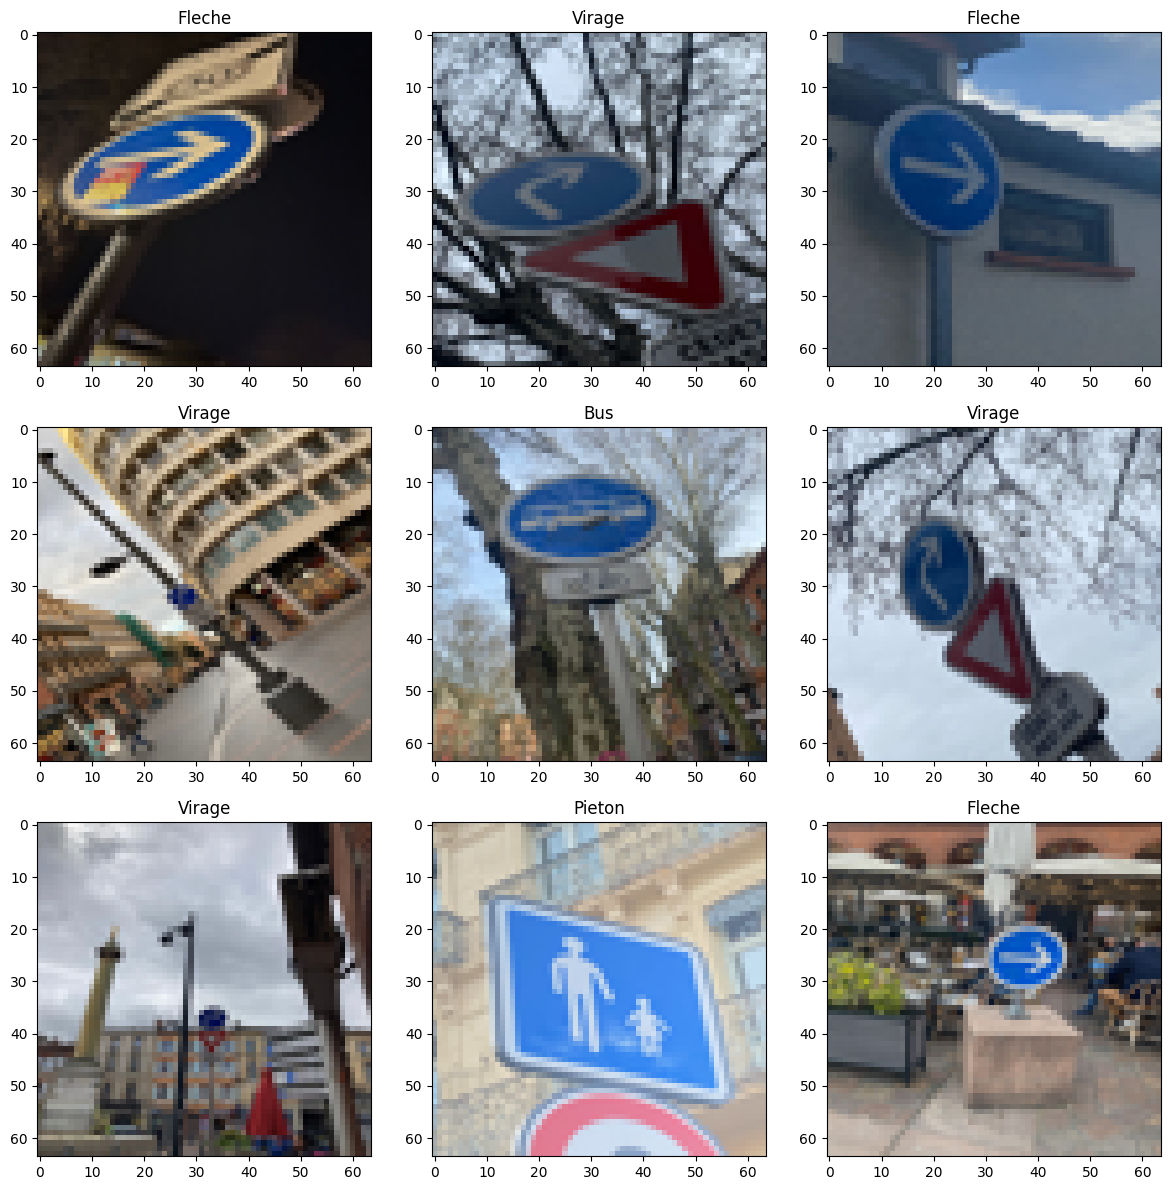

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
shuffle_indices = np.random.permutation(x_train.shape[0])
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x_train[shuffle_indices[i]]
    plt.title(labels[int(y_train[shuffle_indices[i]])])
    plt.imshow(image/255)

plt.tight_layout()
plt.show()

***Etape 1:***# Entrainement

---
Nous allons implémenter l'apprentissage et l'inférence d'un réseau de neurones. En pratique, il est plus courant de faire appel à des librairies qui masquent la complexité de ces algorithmes (notamment le calcul des gradients, réalisé par différentiation automatique. Dans la suite, nous utiliserons la librairie Keras. Dans un premier temps, nous allons détailler sur un exemple simple les différentes étapes à mettre en place pour entraîner un réseau à l'aide de cette librairie.


Définition du réseau

In [11]:
import tensorflow

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), activation='relu'))

model.add(MaxPooling2D(2, 2))
# 2ème couche
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
# 3ème couche
model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
# 4ème couche
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense  
model.add(Dense(512, activation='relu'))   # Couche dense, à 512 neurones
model.add(Dense(4, activation='softmax'))   # Couche de sortie

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 96)         0

Lancement de l'entraînement :)

In [13]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_saver = ModelCheckpoint('tmp/best_weights', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=10, callbacks=[model_saver])

Epoch 1/10
109/109 [==============================] - ETA: 0s - loss: 2.0313 - accuracy: 0.4461
Epoch 1: val_loss improved from inf to 1.05984, saving model to tmp/best_weights
109/109 [==============================] - 13s 11ms/step - loss: 2.0313 - accuracy: 0.4461 - val_loss: 1.0598 - val_accuracy: 0.5588
Epoch 2/10
107/109 [============================>.] - ETA: 0s - loss: 0.8850 - accuracy: 0.6514
Epoch 2: val_loss did not improve from 1.05984
109/109 [==============================] - 1s 5ms/step - loss: 0.8842 - accuracy: 0.6516 - val_loss: 1.1299 - val_accuracy: 0.5000
Epoch 3/10
104/109 [===========================>..] - ETA: 0s - loss: 0.6536 - accuracy: 0.7606
Epoch 3: val_loss improved from 1.05984 to 0.74182, saving model to tmp/best_weights
109/109 [==============================] - 1s 7ms/step - loss: 0.6504 - accuracy: 0.7594 - val_loss: 0.7418 - val_accuracy: 0.7279
Epoch 4/10
106/109 [============================>.] - ETA: 0s - loss: 0.4512 - accuracy: 0.8500
Epoch 4:

Analyse des résultats obtenus

In [18]:
def plot_training_analysis():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

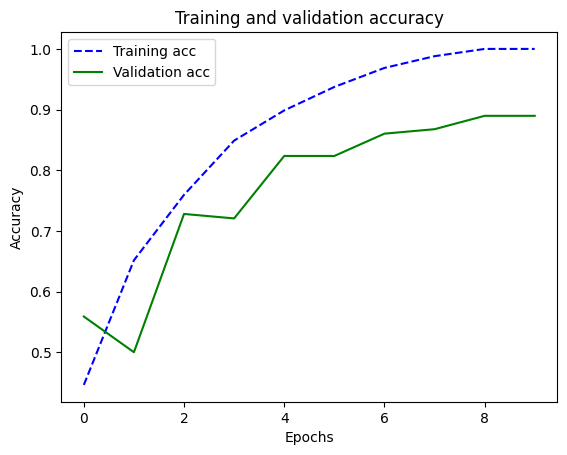

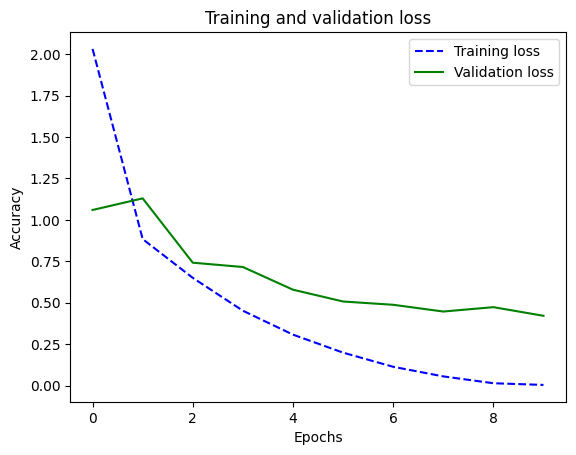

In [19]:
plot_training_analysis()

#Matrices de confusion

Avant de charger les meilleurs poids

34/34 [==============================] - 0s 6ms/step


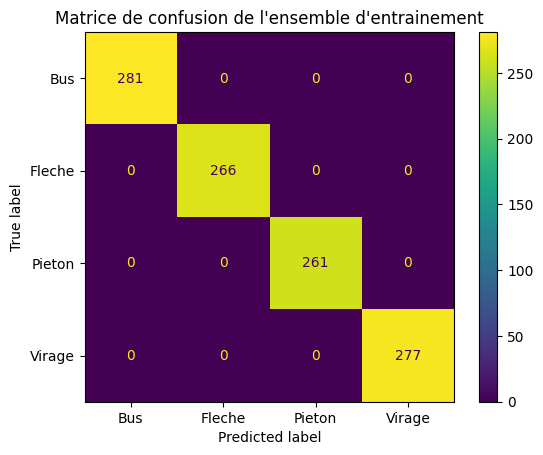

5/5 [==============================] - 0s 29ms/step


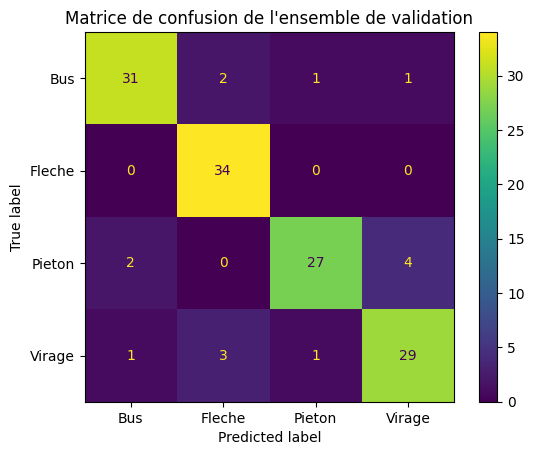

5/5 [==============================] - 0s 5ms/step


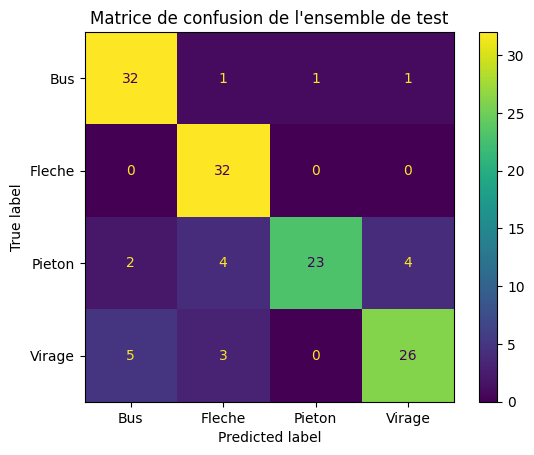

In [20]:
from sklearn import metrics
#Matrice de confusion de l'ensemble d'entrainement

y_train_pred = model.predict(x_train)
cm_train = metrics.confusion_matrix(y_train, np.expand_dims(np.argmax(y_train_pred, axis=1),1))
cm_display_train = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = labels)
cm_display_train.plot()
plt.title("Matrice de confusion de l'ensemble d'entrainement")
plt.show()

#Matrice de confusion de l'ensemble de validation
y_val_pred = model.predict(x_val)
cm_val = metrics.confusion_matrix(y_val, np.expand_dims(np.argmax(y_val_pred, axis=1),1))
cm_display_val = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_val, display_labels = labels)
cm_display_val.plot()
plt.title("Matrice de confusion de l'ensemble de validation")
plt.show()

#Matrice de confusion de l'ensemble de test
y_test_pred = model.predict(x_test)
cm_test = metrics.confusion_matrix(y_test, np.expand_dims(np.argmax(y_test_pred, axis=1),1))
cm_display_test = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = labels)
cm_display_test.plot()
plt.title("Matrice de confusion de l'ensemble de test")
plt.show()

On observe sur  le graphique de précision que la précision est quasi à 100% pour l'ensemble d'apprentissage mais qu'elle stagne autour de 85% pour l'ensemble de validation. On en déduit que notre réseau a légèrement surappris : le réseau s'est "trop" adapté à la base de données et n'arrive donc pas à généraliser avec les images de l'ensemble de validation. Nous allons donc mettre en oeuvre des stratégies pour corriger ce surapprentissage.

Après chargement des meilleurs poids

34/34 [==============================] - 0s 3ms/step


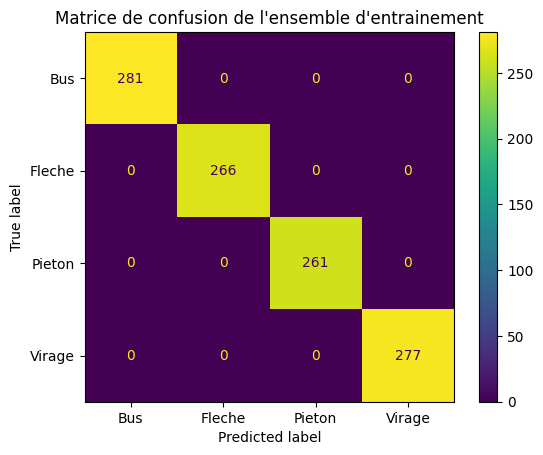

5/5 [==============================] - 0s 4ms/step


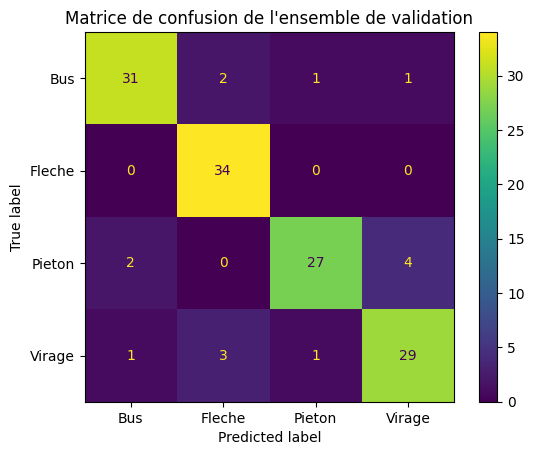

5/5 [==============================] - 0s 3ms/step


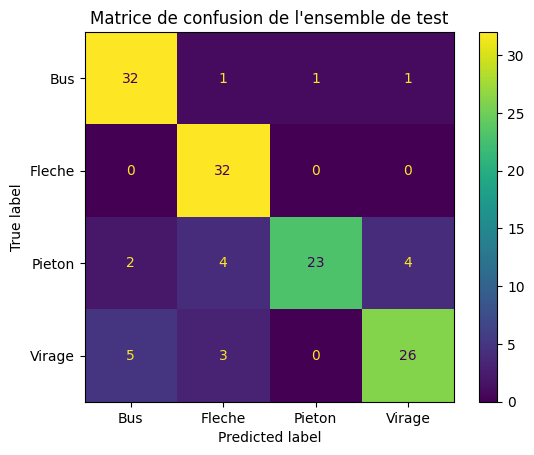

In [21]:
#Matrice de confusion de l'ensemble d'entrainement
model.load_weights('tmp/best_weights')
y_train_pred = model.predict(x_train)
cm_train = metrics.confusion_matrix(y_train, np.expand_dims(np.argmax(y_train_pred, axis=1),1))
cm_display_train = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = labels)
cm_display_train.plot()
plt.title("Matrice de confusion de l'ensemble d'entrainement")
plt.show()

#Matrice de confusion de l'ensemble de validation
y_val_pred = model.predict(x_val)
cm_val = metrics.confusion_matrix(y_val, np.expand_dims(np.argmax(y_val_pred, axis=1),1))
cm_display_val = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_val, display_labels = labels)
cm_display_val.plot()
plt.title("Matrice de confusion de l'ensemble de validation")
plt.show()

#Matrice de confusion de l'ensemble de test
y_test_pred = model.predict(x_test)
cm_test = metrics.confusion_matrix(y_test, np.expand_dims(np.argmax(y_test_pred, axis=1),1))
cm_display_test = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = labels)
cm_display_test.plot()
plt.title("Matrice de confusion de l'ensemble de test")
plt.show()

<ipython-input-22-2e812ee43fae>:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  indImages = np.where((x_true==classe_1)&(y_pred==classe_2))[0]


TypeError: ignored

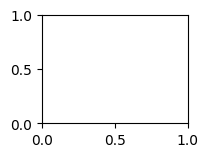

In [22]:
def afficherImagesMalClassees(x_true, y_pred, classe_1, classe_2):
  indImages = np.where((x_true==classe_1)&(y_pred==classe_2))[0]
  for i in indImages:
    image = x_train[i]
    plt.title(labels[int(y_train[shuffle_indices[i]])])
    plt.imshow(image/255)

plt.tight_layout()
plt.show()
shuffle_indices = afficherImagesMalClassees(x_train,y_train_pred,'Pieton','Virage')


# Augmentation de données

Création d'un objet *ImageDataGenerator* pour appliquer des transformations supplémentaires aux images de notre base de données. Nous allons appliquer 4 transformations à nos images :
- une rotation de 40 degrés ;
- un déplacement en largeur de 30% de la largeur ;
- un déplacement en hauteur de 30% de la hauteur ;
- un zoom de 20%.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2)

La cellule suivante nous permet de visualiser des images passées à travers notre boucle d'augmentation de données :

In [ ]:
example_x, example_y = train_datagen.flow(x_train, y_train, batch_size=1).next()
for i in range(0,1):
    plt.imshow(example_x[i]/255)
    plt.title(labels[int(example_y[i])])
    plt.show()

Nous pouvons maintenant recréer notre modèle et relancer l'entraînement.

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), activation='relu'))

model.add(MaxPooling2D(2, 2))
# 2ème couche
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
# 3ème couche
model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
# 4ème couche
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense  
model.add(Dense(512, activation='relu'))   # Couche dense, à 512 neurones
model.add(Dense(4, activation='softmax'))   # Couche de sortie



In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['sparse_categorical_accuracy'])

model_saver = ModelCheckpoint('tmp/best_weights', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')
history = model.fit(train_datagen.flow(x_train, y_train, batch_size=10),
                    validation_data=(x_val, y_val),
                    epochs=50,
                    batch_size=16,callbacks=[model_saver])

In [ ]:
def plot_training_analysis_2():
  acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

In [ ]:
plot_training_analysis_2()

# Matrices de confusion


Avant de charger les meilleurs poids

In [ ]:
from sklearn import metrics
#Matrice de confusion de l'ensemble d'entrainement
y_train_pred = model.predict(x_train)
cm_train = metrics.confusion_matrix(y_train, np.expand_dims(np.argmax(y_train_pred, axis=1),1))
cm_display_train = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = labels)
cm_display_train.plot()
plt.title("Matrice de confusion de l'ensemble d'entrainement")
plt.show()

#Matrice de confusion de l'ensemble de validation
y_val_pred = model.predict(x_val)
cm_val = metrics.confusion_matrix(y_val, np.expand_dims(np.argmax(y_val_pred, axis=1),1))
cm_display_val = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_val, display_labels = labels)
cm_display_val.plot()
plt.title("Matrice de confusion de l'ensemble de validation")
plt.show()

#Matrice de confusion de l'ensemble de test
y_test_pred = model.predict(x_test)
cm_test = metrics.confusion_matrix(y_test, np.expand_dims(np.argmax(y_test_pred, axis=1),1))
cm_display_test = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = labels)
cm_display_test.plot()
plt.title("Matrice de confusion de l'ensemble de test")
plt.show()

Après chargement des meilleurs poids

In [ ]:
#Matrice de confusion de l'ensemble d'entrainement
model.load_weights('tmp/best_weights')
y_train_pred = model.predict(x_train)
cm_train = metrics.confusion_matrix(y_train, np.expand_dims(np.argmax(y_train_pred, axis=1),1))
cm_display_train = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = labels)
cm_display_train.plot()
plt.title("Matrice de confusion de l'ensemble d'entrainement")
plt.show()

#Matrice de confusion de l'ensemble de validation
y_val_pred = model.predict(x_val)
cm_val = metrics.confusion_matrix(y_val, np.expand_dims(np.argmax(y_val_pred, axis=1),1))
cm_display_val = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_val, display_labels = labels)
cm_display_val.plot()
plt.title("Matrice de confusion de l'ensemble de validation")
plt.show()

#Matrice de confusion de l'ensemble de test
y_test_pred = model.predict(x_test)
cm_test = metrics.confusion_matrix(y_test, np.expand_dims(np.argmax(y_test_pred, axis=1),1))
cm_display_test = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = labels)
cm_display_test.plot()
plt.title("Matrice de confusion de l'ensemble de test")
plt.show()